<a href="https://colab.research.google.com/github/basel5621/depi-project/blob/main/Training_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr' -O train.csv

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IlceQkBYvn4VCQH5Rx7jV7rD2NjDdgkU' -O test.csv

--2024-10-11 11:24:57--  https://docs.google.com/uc?export=download&id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr
Resolving docs.google.com (docs.google.com)... 142.251.2.100, 142.251.2.102, 142.251.2.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr&export=download [following]
--2024-10-11 11:24:58--  https://drive.usercontent.google.com/download?id=1Ub8fqb0IG6Y2qfOM1YJMP3eWnDAJbcUr&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39529308 (38M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]  37.70M  72.7MB/s    in 0.5s    


In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()

,cleaned_text,label
0,already tested blood 1947 long game ethnic cle...,1.0
1,yep thats hate bad,0.0
2,dream,1.0
3,uk first past post electoral system broken lea...,0.0
4,excited welcome one newest member team michell...,1.0


In [ ]:
X=df_train['cleaned_text'].astype(str)
y=df_train['label']

X_test=df_test['cleaned_text'].astype(str)
y_test=df_test['label']

X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 441353 entries, 0 to 441352
Series name: cleaned_text
Non-Null Count   Dtype 
--------------   ----- 
441353 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


# Training Word2Vec model

In [ ]:
X_token=X.apply(word_tokenize)
model_w2v = Word2Vec(X_token, vector_size=50, window=5, min_count=1, workers=8, sg=0)

In [ ]:
print(model_w2v.wv.most_similar('happy'))

[('lnt', 0.7261228561401367), ('blessed', 0.7246106863021851), ('thankful', 0.7221375107765198), ('grateful', 0.7055463194847107), ('hoping', 0.6868961453437805), ('glad', 0.6837871670722961), ('happiest', 0.6827980875968933), ('proud', 0.6753768920898438), ('gardenia', 0.6663734316825867), ('choicesalute', 0.6647347807884216)]


In [ ]:
print(model_w2v.wv.most_similar('love'))

[('loved', 0.6988630890846252), ('friendship', 0.6960781812667847), ('enjoy', 0.694290041923523), ('joy', 0.653769314289093), ('beautiful', 0.6425268650054932), ('adore', 0.6312402486801147), ('todaybroke', 0.6283645033836365), ('appreciate', 0.6280300617218018), ('kindness', 0.624562680721283), ('amazing', 0.6237467527389526)]


In [ ]:
model_w2v.save("word2vec.model")

In [ ]:
loaded_model = Word2Vec.load("word2vec.model")

# Converting text to sequences

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

vocab_size = len(tokenizer.word_index)+1

X_train_seq = tokenizer.texts_to_sequences(X)

max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq , maxlen=max_len , padding='post')
vocab_size

181849

# Creating embedding matrix

In [ ]:
embedding_dim = model_w2v.vector_size  # 300 in your case
embedding_matrix = np.zeros((vocab_size, model_w2v.vector_size))
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

In [ ]:
embedding_matrix.shape

(181849, 50)

# saving

In [ ]:
import pickle
with open('tokenizer5.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Trianing model

In [ ]:
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense ,Dropout
from tensorflow.keras import layers


BI_LSTM_model = Sequential([
    layers.Input(shape=(max_len,)),
    layers.Embedding(input_dim=vocab_size, output_dim=model_w2v.vector_size, weights=[embedding_matrix], trainable=False),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))),
    layers.GlobalMaxPool1D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

BI_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

BI_LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 68, 50)              │       9,092,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 68, 512)             │         628,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,786,979 (37.33 MB)

 Trainable params: 694,529 (2.65 MB)

 Non-trainable params: 9,092,450 (34.68 MB)

In [ ]:
BI_history=BI_LSTM_model.fit(X_train_padded, y, epochs=100, batch_size=512, validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 57s 65ms/step - accuracy: 0.9606 - loss: 0.4616 - val_accuracy: 0.9861 - val_loss: 0.0508
Epoch 2/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - accuracy: 0.9840 - loss: 0.0541 - val_accuracy: 0.9867 - val_loss: 0.0461
Epoch 3/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9851 - loss: 0.0509 - val_accuracy: 0.9865 - val_loss: 0.0446
Epoch 4/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9853 - loss: 0.0481 - val_accuracy: 0.9875 - val_loss: 0.0429
Epoch 5/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.9856 - loss: 0.0465 - val_accuracy: 0.9866 - val_loss: 0.0428
Epoch 6/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.9855 - loss: 0.0461 - val_accuracy: 0.9871 - val_loss: 0.0409
Epoch 7/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.9859 - loss: 0.0441 - val_accuracy: 0.9874 - val_loss: 0.0395
Epoch 8/100
776/776 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.9859 - loss: 0

<Axes: >

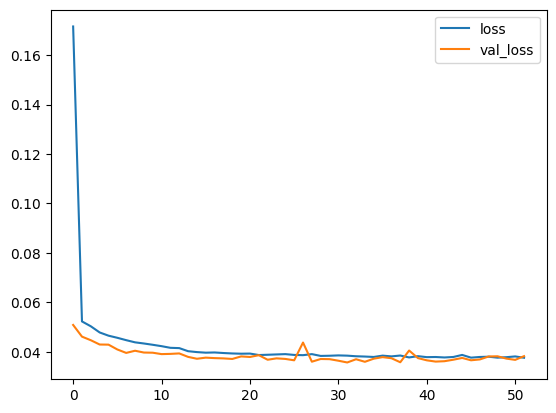

In [ ]:
df_hist_BI=pd.DataFrame(BI_history.history)
df_hist_BI[['loss','val_loss']].plot()

In [ ]:
BI_LSTM_model.save("BI_LSTM_model.keras")

# Testing

In [ ]:
def myscore(X,y,model,tokenizer=tokenizer):
  X_seq=tokenizer.texts_to_sequences(X.tolist())
  X_padded=pad_sequences(X_seq,maxlen=max_len,padding='post')
  loss,acc=model.evaluate(X_padded,y)
  return loss,acc

def predict_sentiment(sentence, model , tokenizer=tokenizer):

    sequences = tokenizer.texts_to_sequences([sentence])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    prediction = model.predict(padded_sequences,verbose=0)
    print(f"Prediction: {prediction[0][0]}")
    if prediction >= 0.5:
        return "Positive"
    else:
        return "Negative"

## Test model

In [ ]:
loss,acc = myscore(X_test , y_test , model=BI_LSTM_model)
print(f'loss={loss},accuracy={acc*100}')

1533/1533 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9874 - loss: 0.0360
loss=0.03507419675588608,accuracy=98.77854585647583


In [ ]:
predict_sentiment("i love ai", model=BI_LSTM_model) #

Prediction: 0.39987343549728394


'Negative'

In [ ]:
predict_sentiment("i hate ai", model=BI_LSTM_model)

Prediction: 0.38733750581741333


'Negative'

In [ ]:
predict_sentiment("i very happy", model=BI_LSTM_model) #

Prediction: 0.3601299524307251


'Negative'

In [ ]:
predict_sentiment("This is the best movie I've seen in years!", model=BI_LSTM_model)

Prediction: 0.9846807718276978


'Positive'

In [ ]:
predict_sentiment("I absolutely hate how slow this service is.", model=BI_LSTM_model)

Prediction: 0.3525691628456116


'Negative'

In [ ]:
feedbacks = [
    "The product quality is amazing, I love it!",
    "I'm not satisfied with the customer support.",
    "This is the best service I've used in a while.",
    "The delivery took too long, very disappointed.",
    "The price is reasonable, but the quality could be better.",
    "Excellent experience! Will definitely recommend.",
    "Terrible customer service, will not come back.",
    "I'm neutral about the product. It's okay, not great.",
    "I absolutely hate how slow this service is.",
    "Very efficient and quick response. Highly satisfied!"
]

def predict_sentiments(feedback_list, model):
    for feedback in feedback_list:
        sentiment = predict_sentiment(feedback, model=model)
        print(f"Feedback: {feedback}\nPredicted Sentiment: {sentiment}\n")

predict_sentiments(feedbacks, model=BI_LSTM_model)


Prediction: 0.6427643299102783
Feedback: The product quality is amazing, I love it!
Predicted Sentiment: Positive

Prediction: 0.3707877993583679
Feedback: I'm not satisfied with the customer support.
Predicted Sentiment: Negative

Prediction: 0.9817919135093689
Feedback: This is the best service I've used in a while.
Predicted Sentiment: Positive

Prediction: 0.3502042591571808
Feedback: The delivery took too long, very disappointed.
Predicted Sentiment: Negative

Prediction: 0.37375757098197937
Feedback: The price is reasonable, but the quality could be better.
Predicted Sentiment: Negative

Prediction: 0.40944796800613403
Feedback: Excellent experience! Will definitely recommend.
Predicted Sentiment: Negative

Prediction: 0.36703574657440186
Feedback: Terrible customer service, will not come back.
Predicted Sentiment: Negative

Prediction: 0.3961358666419983
Feedback: I'm neutral about the product. It's okay, not great.
Predicted Sentiment: Negative

Prediction: 0.3525691628456116
F

## Classification report and confusion matrix

In [ ]:
def Predict(X,y):
  X_seq=tokenizer.texts_to_sequences(X.tolist())
  X_padded=pad_sequences(X_seq,maxlen=max_len,padding='post')

  y_pred = BI_LSTM_model.predict(X_padded,verbose=0)
  return y_pred

In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    report = classification_report(y_true, y_pred_rounded, target_names=['Negative', 'Positive'])
    print(report)

y_pred = Predict(X_test,y_test)
print_classification_report(y_test, y_pred)

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99     24433
    Positive       0.99      0.98      0.99     24607

    accuracy                           0.99     49040
   macro avg       0.99      0.99      0.99     49040
weighted avg       0.99      0.99      0.99     49040



In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)
    cm = confusion_matrix(y_true, y_pred_rounded)
    return cm

def plot_confusion_matrix(cm, labels=['Negative', 'Positive']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


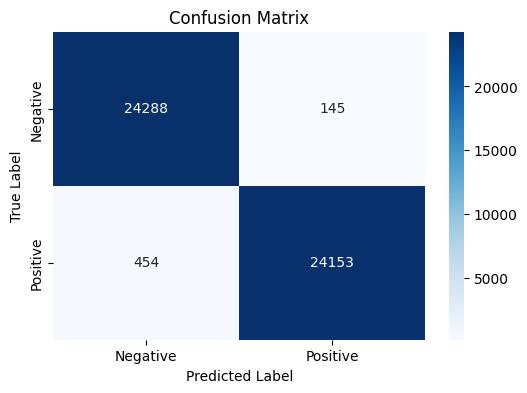

In [ ]:
cm=compute_confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)